In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import functions 
import yfinance as yf
import scipy.stats as st
# Web scraping
import requests
from bs4 import BeautifulSoup

## Web Scrapping

In [2]:
def webScrapping(url : "Link de los ETF's", CLASS : "Tipo(s) de dato(s) a scrapear"):

    # Scrapeo de datos de Morningstar
    page = requests.get(url)
    page_content = page.content
    soup = BeautifulSoup(page_content, "html.parser")
    results = {}
    
    for (class_i, title) in zip(CLASS, ["Sector", "Región"]):
        labels = soup.find_all("table", {"class" : class_i})

        for label in labels:
            text = label.get_text()
    
        text = text[text.find("%") + 1 : ]
        idx = []
        for i in range(len(text)):
            if text[i] in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "."]:
                idx.append(i)

        newIdx = [1] + list(np.diff(idx))
        allIdx = []
             
        for i in range(len(newIdx)):
            if newIdx[i] != 1:
                allIdx.append(idx[i - 1])
        
        allIdx = [0] + allIdx + [idx[-1]]

        info = []
        for i in range(len(allIdx) - 1):
            if i == 0:
                info.append(text[allIdx[i] : allIdx[i + 1] + 1])
            else:
                info.append(text[allIdx[i] + 1 : allIdx[i + 1] + 1])
    
        def text_num_split(item):
            for index, letter in enumerate(item, 0):
                if letter.isdigit():
                    return item[:index], item[index:]

        labels, values = [], []
        for i in info:
            label, value = text_num_split(i)
            labels.append(label)
            values.append(float(value))
    
        data = pd.DataFrame(values, index = labels, columns = [title])
        data.loc["Otros"] = 100 - data[title].sum()
        results[title] = data
    
    return results

CLASS = ["snapshotTextColor snapshotTextFontStyle snapshotTable overviewTopSectorsTable",
         "snapshotTextColor snapshotTextFontStyle snapshotTable overviewTopRegionsTable"]
res = webScrapping("https://www.morningstar.com.mx/mx/funds/snapshot/snapshot.aspx?id=F000002DF3", CLASS)
res["Sector"]

,Sector
Servicios Financieros,17.67
Tecnología,17.39
Consumo Cíclico,10.18
Industria,10.07
Consumo Defensivo,10.05
Otros,34.64


In [3]:
res["Región"]

,Región
Estados Unidos,58.93
Latinoamérica,11.77
Europe - ex Euro,5.19
Zona Euro,4.85
Japón,4.25
Otros,15.01


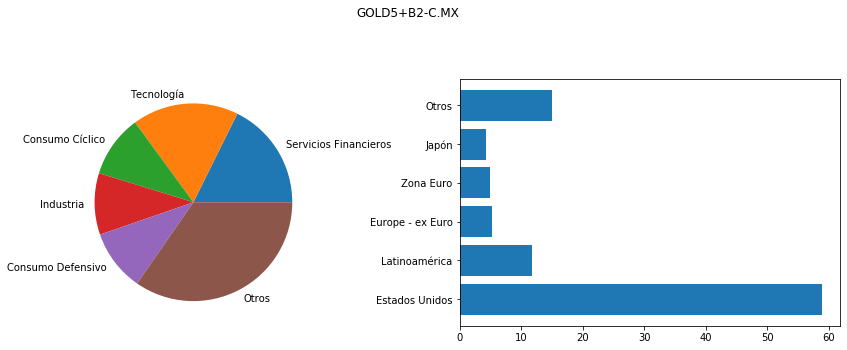

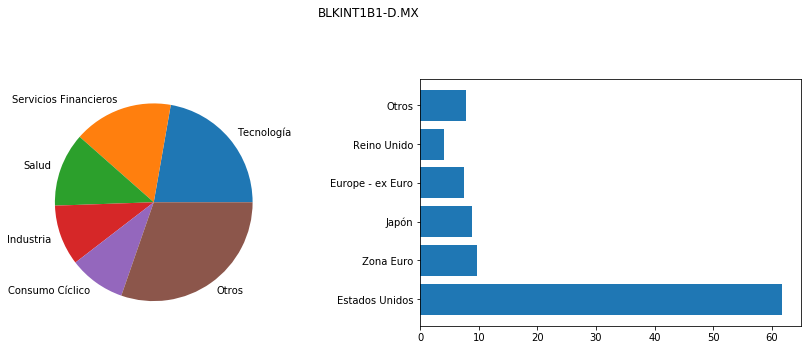

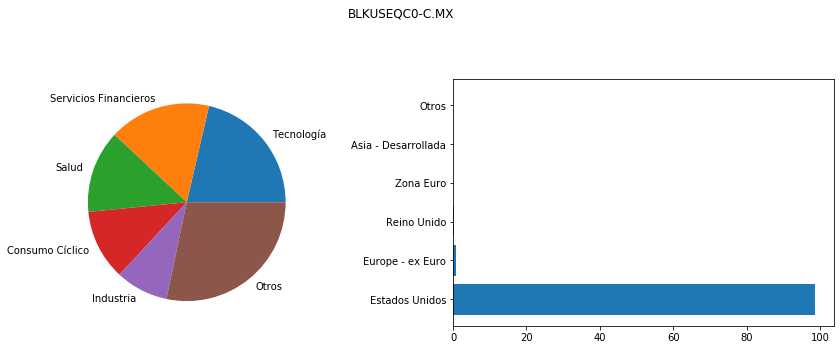

In [4]:
urls = ["https://www.morningstar.com.mx/mx/funds/snapshot/snapshot.aspx?id=F000002DF3",
        "https://www.morningstar.com.mx/mx/funds/snapshot/snapshot.aspx?id=F00000GWPB",
        "https://www.morningstar.com.mx/mx/funds/snapshot/snapshot.aspx?id=F000003WX1"]

tickers = ["GOLD5+B2-C.MX", "BLKINT1B1-D.MX", "BLKUSEQC0-C.MX"]


for (url, ticker) in zip(urls, tickers): 
    
    # Web scrapping
    res = webScrapping(url, CLASS)
    
    # Visualización
    fig = plt.figure(figsize = (15, 10))
    fig.suptitle(ticker)
    keys = list(res.keys())
    
    # Exposición sectorial
    sub1 = fig.add_subplot(2, 2, 1)
    sub1.pie(res[keys[0]][keys[0]].values, labels = res[keys[0]].index); 
    
    # Exposición geográfica
    sub2 = fig.add_subplot(2, 2, 2)
    sub2.barh(res[keys[1]].index, res[keys[1]][keys[1]].values); 
    #for i in range(len(res[keys[1]])):
    #    sub2.text(res[keys[1]].iloc[i, 0], res[keys[1]].index[i], str(round(res[keys[1]].iloc[i, 0], 2)) + str("%"))
    

## Risk Analysis

def brownianMotion(historicPrices : "DataFrame con los precios históricos de los ETF's",
                significanceLevel : "Nivel de significancia %", colors : "colores"):
    plt.style.use('seaborn')

    for i in range(len(historicPrices.iloc[0])):
        
        # Parámetros históricos
        returns = historicPrices.iloc[:, i].dropna().pct_change().dropna()
        mu, sigma = np.mean(returns), np.std(returns)
    
        # Simulación de precios
        idx = pd.bdate_range(returns.index[-1] + dt.timedelta(1), end = returns.index[-1] + dt.timedelta(365))
        d_t = np.arange(1, len(idx) + 1)
        expectedPrice = pd.Series(historicPrices.iloc[-1, i] * np.exp((mu - (sigma ** 2) / 2) * d_t), idx)
        
        # Intervalos de confianza
        Z = st.norm.ppf(1 - significanceLevel / 2)
        infLim = pd.Series(np.exp(np.log(historicPrices.iloc[-1, i]) + (mu - (sigma ** 2) / 2) * d_t - Z * (sigma * np.sqrt(d_t))), idx)
        supLim = pd.Series(np.exp(np.log(historicPrices.iloc[-1, i]) + (mu - (sigma ** 2) / 2) * d_t + Z * (sigma * np.sqrt(d_t))), idx)
        
        # Visualización
        fig, axes = plt.subplots(1, 1, figsize = (15, 3.5))
        fig.suptitle("Simulación de precios: " + historicPrices.columns[i])
        
        axes.plot(historicPrices.iloc[:, i], color = colors[i], label = "Cierre")
        axes.plot(expectedPrice, "--", color = "k", label = "E[Precio]: $" + str(round(expectedPrice[-1], 2)))
        axes.fill_between(expectedPrice.index, infLim, supLim, color = colors[i], alpha = 0.25, 
                          label = "Intervalo confianza " + str(100 - significanceLevel * 100) + "%")
        axes.legend(loc = "upper left")
        axes.set_xlabel("Fecha")
        axes.set_ylabel("$ (MXN)")

def riskAnalysis(historicPrices : "DataFrame con los precios históricos de los ETF's",
                confidenceLevel : "Nivel de confianza", colors : "colores"):
    plt.style.use('seaborn')
    
    for i in range(len(historicPrices.iloc[0])):
    
        # Rendimientos
        returns = historicPrices.iloc[:, i].dropna().pct_change().dropna()
    
        # VaR y Expected Shortfall
        VaR = np.percentile(returns, 100 - confidenceLevel) 
        ES = np.mean(returns[returns < VaR])
    
        # Visualización
        fig, axes = plt.subplots(1, 2, figsize = (15, 3.5))
        fig.suptitle("Value at Risk & Expected Shortfall: " + historicPrices.columns[i])
        
        axes[0].hist(returns, bins = 30, density = True, alpha = 0.35, color = colors[i])
        axes[0].axvline(x = VaR, label = "VaR " + str(confidenceLevel) + "% : " + str(round(VaR * 100, 2)) + "%", linestyle = "--", color = colors[i])
        axes[0].axvline(x = ES, label = "ES " + str(confidenceLevel) + "% : " + str(round(ES * 100, 2)) + "%", linestyle = "--", color = "k")
        axes[0].set_xlabel("Rendimientos")
        axes[0].legend()
    
        # Backtesting
        returns = pd.DataFrame(returns)
        returns["VaR%"] = np.nan
        returns["Expected Shortfall"] = np.nan

        j = 0
        for k in range(len(returns)):    
            if returns.index[k] >= pd.to_datetime("2020-01-01"): 
                returns.iloc[k, 1] = np.percentile(returns.iloc[j : k, 0], 100 - confidenceLevel)
                returns.iloc[k, 2] = np.mean(returns.iloc[j : k, 0][returns.iloc[j : k, 0] < returns.iloc[k, 1]])
                j += 1
        
        # Visualización
        returns.dropna(inplace = True)
        axes[1].plot(returns.iloc[:, 0], label = "Retornos", color = colors[i], alpha = 0.35)
        axes[1].plot(returns.iloc[:, 1], label = "Backtesting: VaR", color = colors[i])
        axes[1].plot(returns.iloc[:, 2], label = "Backtesting: ES", color = "k")
        axes[1].set_ylabel("%")
        axes[1].set_xlabel("Fecha")
        axes[1].legend()
            